### Loading the required modeuls 

In [1]:
import bs4
import requests
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import urllib.request
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt

# Task 1: Web Scrapping and storing data in three seperate databases
We will scrape all the reviews from 3 review categories, **Automotive**, **Cafes** and **Hotel**. The reviews are stored in 3 seperate datasets.

In [2]:
category  = ['http://mlg.ucd.ie/modules/yalp/automotive_list.html','http://mlg.ucd.ie/modules/yalp/cafes_list.html','http://mlg.ucd.ie/modules/yalp/hotels_list.html']
go = []

for x in category:
    y=[]
    response = urllib.request.urlopen(x)
    html = response.read().decode()
    soup = bs4.BeautifulSoup(html,"html.parser")
    for i in soup.findAll('a'):
        y.append(i.get('href'))  #consists of a list of links for all the bussinesses for each category
        
    go.append(y)

In [3]:
link = "http://mlg.ucd.ie/modules/yalp/"
go = [ [link+x for x in y] for y in go]

In [4]:
data = []
i = 0

for url in go:
    review= []
    rating = []
    
    for x in url:
        response = urllib.request.urlopen(x)
        html = response.read().decode()
        soup = bs4.BeautifulSoup(html, "html.parser")
        
        for r in soup.find_all('img'):  #finding img tag
            if r.get('alt') !=None:     #alt tag consists the ratings for the reviews
                if int(r.get('alt')[0])>3:
                    rating.append('Positive') #if rating > 3, assigns positive
                else:
                    rating.append('Negative') #if raitng <3, assigns negative
            
     
                
        for r in soup.find_all('p', class_='review-text'):  #finding the review-text class which consists of the review text
            review.append(r.get_text())
            
    data.append(pd.DataFrame(review))
    data[i]['rating']=rating
    i=i+1

        

In [5]:
data[0].columns=['review','rating'] #Automotive Dataset
data[1].columns=['review','rating'] #Cafes Dataset
data[2].columns=['review','rating'] #Hotels Dataset

In [7]:
#saving the dataframe in csv files
data[0].to_csv('automotive_data.csv', encoding='utf-8', index=False)
data[1].to_csv('cafe_data.csv', encoding='utf-8', index=False)
data[2].to_csv('hotel_data.csv', encoding='utf-8', index=False)

# Task 2:

### Loading all the required CSV files 
We are loading the three csv files we created by scraping the reviews and ratings from 3 categories, **Automotive**, **Cafes** and **Hotels**. 

In [6]:
df1 = pd.read_csv('automotive_data.csv', index_col=None )
df2 = pd.read_csv('cafe_data.csv', index_col=None )
df3 = pd.read_csv('hotel_data.csv', index_col=None )

## Categroy 1.  Automotive 

In [8]:
df1.head()

,review,rating
0,The man that was working tonight (8-12-17) was...,Negative
1,Chris is a very rude person. Gave me an attitu...,Negative
2,One of my favorite gas station to stop at. The...,Positive
3,Oh thank Heaven for Seven Eleven! I don't know...,Negative
4,Five stars because of the guy who works weekda...,Positive


In [9]:
df1['rating'].value_counts()

Positive    1212
Negative     788
Name: rating, dtype: int64

For the automotive dataset, there are 1212 positive reviewsand 788 negative reviews.

In [10]:
review = df1["review"]
target = df1["rating"]
print("Read %d documents" % len(df1))

Read 2000 documents


### <font color='Red'>Preprocessing to create a numerical representation of data</font>
To preprocess the data, we are using TFidfVectorizer. It creates a numeric representation of data that can be used as input to the estimator. It tokenizes the document, and converts the document in lowercase. It also removes the tokens of lengh 1. We are futher performaing a few other preprocessing steps such as removal of stop words, by using the built-in stop words list by specifying the language. Further we are considering unigrams and bigrams. Minimum document frequency for the term is 2.

In [11]:
vectorizer = TfidfVectorizer(ngram_range = (1,2), stop_words='english', min_df =2)
X = vectorizer.fit_transform(review)
print(X.shape)
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

(2000, 13600)
Vocabulary has 13600 distinct terms


In [12]:
# Displaying a set of sample terms
print(terms[2000:2010])

['car suddenly', 'car super', 'car supposed', 'car sure', 'car taken', 'car takes', 'car talk', 'car tech', 'car tell', 'car tells']


In [13]:
data_train, data_test, target_train, target_test = train_test_split(X, target, test_size=0.2)

### **<font color='Red'>Training the model</font>**
We are using Logistic Regression here. The model is trained on the training set so that it can classify unseen data, i.e. the test set.

In [14]:
model = LogisticRegression(random_state=0)
model.fit(data_train, target_train)

/Users/sahil/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### <font color='Red'>Testing and evaluation</font>
The model is tested on the test data which is the unseen data. The model classifies the unseen data, in positive or  negative classes.

We are using classification report and confusion matrix for evaluating the model. 

In [15]:
predicted = model.predict(data_test)
print("Accuracy = %.2f" % accuracy_score(target_test, predicted) )
m1 = accuracy_score(target_test, predicted)
print(metrics.classification_report(target_test, predicted, target_names=df1['rating'].unique())) 
display(pd.crosstab(target_test, predicted, rownames=["True"],colnames = ['Predicted'], margins = True))

Accuracy = 0.86
              precision    recall  f1-score   support

    Negative       0.92      0.72      0.81       167
    Positive       0.83      0.96      0.89       233

    accuracy                           0.86       400
   macro avg       0.88      0.84      0.85       400
weighted avg       0.87      0.86      0.86       400



Predicted,Negative,Positive,All
True,,,
Negative,121,46,167
Positive,10,223,233
All,131,269,400


## Category 2. Cafe 

In [16]:
df2.head()

,review,rating
0,Pros: Lots of items you would not expect from ...,Positive
1,Best egg-tarts in town! There's really not muc...,Positive
2,I've been to ABC Bakery a few times since I re...,Negative
3,"FYI, Closed Monday's New ownership for about 1...",Negative
4,The inside may not look like much but they mak...,Positive


In [17]:
df2['rating'].value_counts()

Positive    1462
Negative     538
Name: rating, dtype: int64

The cafe dataset has 1462 positive reviews and 538 negative reviews.

In [18]:
review = df2["review"]
target = df2["rating"]
print("Read %d documents" % len(df2))

Read 2000 documents


### <font color='Red'>Preprocessing to create a numerical representation of data</font>
Here also we will preprocess the data as we did with the previous dataset, using TfidfVectorizer. Stop words are removed and we are considering unigrams and bigrams. The minimum document frequency of the term is 2.

In [19]:
vectorizer = TfidfVectorizer(ngram_range = (1,2), stop_words='english', min_df=2)
X = vectorizer.fit_transform(review)
print(X.shape)
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

(2000, 13423)
Vocabulary has 13423 distinct terms


In [20]:
# Displaying a set of sample terms
print(terms[2000:2010])

['chocolate chips', 'chocolate chocolate', 'chocolate chunk', 'chocolate cookie', 'chocolate covered', 'chocolate croissant', 'chocolate cupcake', 'chocolate dipped', 'chocolate frozen', 'chocolate fudge']


In [21]:
data_train, data_test, target_train, target_test = train_test_split(X, target, test_size=0.2)

### <font color='Red'>Training the model</font>


In [22]:
model_2 = LogisticRegression(random_state=0)
model_2.fit(data_train, target_train)

/Users/sahil/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### <font color='Red'>Testing and evaluation</font>


In [23]:
predicted = model_2.predict(data_test)
print("Accuracy = %.2f" % accuracy_score(target_test, predicted) )
m2 = accuracy_score(target_test, predicted)
print(metrics.classification_report(target_test, predicted, target_names=df1['rating'].unique())) 
display(pd.crosstab(target_test, predicted, rownames=["True"],colnames = ['Predicted'], margins = True))

Accuracy = 0.81
              precision    recall  f1-score   support

    Negative       0.97      0.29      0.45       103
    Positive       0.80      1.00      0.89       297

    accuracy                           0.81       400
   macro avg       0.88      0.64      0.67       400
weighted avg       0.84      0.81      0.78       400



Predicted,Negative,Positive,All
True,,,
Negative,30,73,103
Positive,1,296,297
All,31,369,400


## Category 3. Hotel 

In [24]:
df3.head()

,review,rating
0,Melissa took us on a tour of Asia in the space...,Positive
1,With a group of seven of us visiting Montreal ...,Positive
2,Melissa is a gem! My fiancé found her tour on ...,Positive
3,A perfect day in Montreal! Melissa outfitted u...,Positive
4,I had a really great food truck tour with Meli...,Positive


In [25]:
df3['rating'].value_counts()

Positive    1176
Negative     824
Name: rating, dtype: int64

The hotel dataset has 1176 positive reviews and 824 negative reviews.

In [26]:
review = df3["review"]
target = df3["rating"]
print("Read %d documents" % len(df3))

Read 2000 documents


### <font color='Red'>Preprocessing to create a numerical representation of data</font>
TfidfVectorizer is being used. Unigram and bigrams are considerd. The stop words have been removed. The minimum document frequency of terms is 2.

In [27]:
vectorizer = TfidfVectorizer(ngram_range = (1,2), stop_words='english', min_df=2)
X = vectorizer.fit_transform(review)
print(X.shape)
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

(2000, 15501)
Vocabulary has 15501 distinct terms


In [28]:
data_train, data_test, target_train, target_test = train_test_split(X, target, test_size=0.2)

### <font color='Red'>Training the model</font>


In [29]:
model_3 = LogisticRegression(random_state=0)
model_3.fit(data_train, target_train)

/Users/sahil/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### <font color='Red'>Testing and evaluation</font>


In [30]:
predicted = model_3.predict(data_test)
print("Accuracy = %.2f" % accuracy_score(target_test, predicted) )
m3 = accuracy_score(target_test, predicted)
print(metrics.classification_report(target_test, predicted, target_names=df1['rating'].unique())) 
display(pd.crosstab(target_test, predicted, rownames=["True"],colnames = ['Predicted'], margins = True))

Accuracy = 0.88
              precision    recall  f1-score   support

    Negative       0.93      0.77      0.84       176
    Positive       0.84      0.96      0.90       224

    accuracy                           0.88       400
   macro avg       0.89      0.86      0.87       400
weighted avg       0.88      0.88      0.87       400



Predicted,Negative,Positive,All
True,,,
Negative,136,40,176
Positive,10,214,224
All,146,254,400


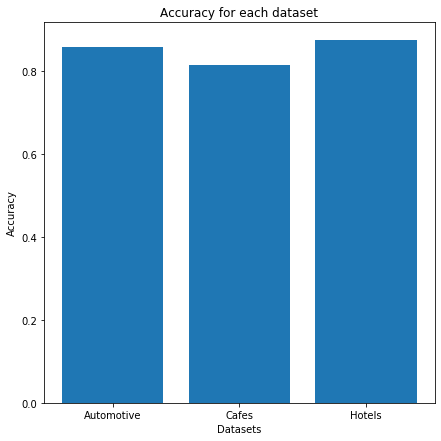

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = [m1,m2,m3]
lables = ['Automotive','Cafes','Hotels']
plt.figure(figsize = (7,7))
plt.bar(lables, data)
plt.title('Accuracy for each dataset')
plt.xlabel('Datasets')
plt.ylabel('Accuracy')
plt.show()

We are considering 3 categories, automotive, cafes and hotels. Logistice regression is being used for all the cases. The model distinguishes between positive and negative reviews. To evalute the predictions we are using the classification report and confusion matrix.

1. The model is trained on the automotive dataset. We are testing the model on the test set(from the original dataset). The accuracy of the model on test set is 0.86, which is good. It can be seen from the confusion matrix that, 121 negative reviews are predicted correctly as negative while only 46 negative reviews are predicted as postive. Further, 269 positive reviews are predicted as postive, while only 10 positive reviews are predicted as negative. The F1 score for the negative reviews in 0.81, while the f1 score for postive reviews is 0.89. This means that the classifier is classifying unseen test data well.

2. The model is trained on the cafe dataset. The accuracy of the model on test set is 0.81, which can be considered good, but we have to look at the confusion matrix. From the confusion matrix, it can be seen that out of 103 negative reviews, only 30 negative reviews are predicted as negative, whereas 73 negative reviews are predicted as positive. Therefore F1 score for negative reviews is 0.45. Further, out of 297 positve reviews, the model is predicting 296 positive reviews as psotive, while only 1 postive review is predicted as negative, which is good. The F1 score for positive reviews  is 0.89. From this we can conclude that, the model is classifying the positive reviews well, but it is not classifying the negative reviews well. So we cannot only depend on the accuracy.

3. The model is trained on the hotel dataset. The accuracy of the model on test set is 0.88, which is considered good, but we will also look at the confusion matrix. It can be seen that out of 176 negative review, 136 negative reviews are correctly predicted as negative whie only 40 negative reviews have been predicted as positive, the model is predicting the negative class well. Further, out of 224 positive reviews, the model is predicting 214 positive reviews as positive while on 10 reviews as negative, which is also good, The F1 score for negative reviews is 0.84, whereas the F1 score for positive reviews is 0.90. This means that the classifier is classifyin the unseen data well.

Out of the three models trained on each dataset, the model trained on Hotels dataset has the highest accuracy, while the model trained on the cafes dataset has lowest accuracy.

# Task 3


## 1. Training on Automotive Dataset
The model will be trained on the automotive dataset.

In [32]:
df1.head()

,review,rating
0,The man that was working tonight (8-12-17) was...,Negative
1,Chris is a very rude person. Gave me an attitu...,Negative
2,One of my favorite gas station to stop at. The...,Positive
3,Oh thank Heaven for Seven Eleven! I don't know...,Negative
4,Five stars because of the guy who works weekda...,Positive


In [33]:
#training set
X_train = df1["review"]
y_train = df1["rating"]

In [34]:
#test set
X_test_1 = df2["review"]
y_test_1 = df2["rating"]
X_test_2 = df3["review"]
y_test_2 = df3["rating"]

### <font color='Red'>Preprocessing</font>

In [35]:
#numeric format for train set
vectorizer = TfidfVectorizer(ngram_range = (1,2), stop_words='english', min_df = 2)
X = vectorizer.fit_transform(X_train)
print(X.shape)
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

(2000, 13600)
Vocabulary has 13600 distinct terms


In [36]:
# Displaying a set of sample terms
print(terms[2000:2010])

['car suddenly', 'car super', 'car supposed', 'car sure', 'car taken', 'car takes', 'car talk', 'car tech', 'car tell', 'car tells']


### <font color='Red'>Training the model</font> 

In [37]:
model_4 = LogisticRegression(random_state=0)
model_4.fit(X, y_train)

/Users/sahil/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### <font color='Red'>Testing and evaluating on Cafe dataset</font>

In [38]:
test_X = vectorizer.transform(X_test_1)
predicted = model_4.predict(test_X)

In [40]:
print("Accuracy = %.2f" % accuracy_score(y_test_1, predicted) )
m1 = accuracy_score(y_test_1, predicted)
print(metrics.classification_report(y_test_1, predicted))
display(pd.crosstab(y_test_1, predicted, rownames=["True"], colnames = ['Predicted'], margins = True))

Accuracy = 0.83
              precision    recall  f1-score   support

    Negative       0.86      0.43      0.57       538
    Positive       0.82      0.98      0.89      1462

    accuracy                           0.83      2000
   macro avg       0.84      0.70      0.73      2000
weighted avg       0.83      0.83      0.81      2000



Predicted,Negative,Positive,All
True,,,
Negative,229,309,538
Positive,36,1426,1462
All,265,1735,2000


### <font color='Red'>Testing and evaluating on Hotel dataset </font>

In [41]:
test_X_2 = vectorizer.transform(X_test_2)
predicted = model_4.predict(test_X_2)

In [42]:
print("Accuracy = %.2f" % accuracy_score(y_test_2, predicted) )
m2 = accuracy_score(y_test_2, predicted)
print(metrics.classification_report(y_test_2, predicted))
display(pd.crosstab(y_test_2, predicted, rownames=["True"],colnames = ['Predicted'], margins = True))

Accuracy = 0.85
              precision    recall  f1-score   support

    Negative       0.94      0.68      0.79       824
    Positive       0.81      0.97      0.89      1176

    accuracy                           0.85      2000
   macro avg       0.88      0.83      0.84      2000
weighted avg       0.87      0.85      0.85      2000



Predicted,Negative,Positive,All
True,,,
Negative,562,262,824
Positive,33,1143,1176
All,595,1405,2000


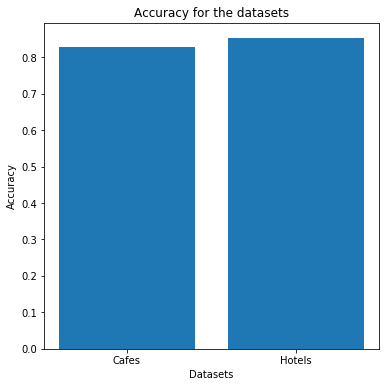

In [44]:
data = [m1,m2]
lables = ['Cafes','Hotels']
plt.figure(figsize = (6,6))
plt.bar(lables, data)
plt.title('Accuracy for the datasets')
plt.xlabel('Datasets')
plt.ylabel('Accuracy')
plt.show()

## 2. Training on Cafe Dataset
The model is trained on cafe dataset.

In [45]:
df2.head()

,review,rating
0,Pros: Lots of items you would not expect from ...,Positive
1,Best egg-tarts in town! There's really not muc...,Positive
2,I've been to ABC Bakery a few times since I re...,Negative
3,"FYI, Closed Monday's New ownership for about 1...",Negative
4,The inside may not look like much but they mak...,Positive


In [46]:
#training set
X_train = df2["review"]
y_train = df2["rating"]

In [47]:
#test set
X_test_1 = df1["review"]
y_test_1 = df1["rating"]
X_test_2 = df3["review"]
y_test_2 = df3["rating"]

### <font color='Red'>Preprocessing</font>

In [48]:
#numeric format for train set
vectorizer = TfidfVectorizer(ngram_range = (1,2), stop_words='english', min_df=2)
X = vectorizer.fit_transform(X_train)
print(X.shape)
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

(2000, 13423)
Vocabulary has 13423 distinct terms


In [49]:
# Displaying a set of sample terms
print(terms[2000:2010])

['chocolate chips', 'chocolate chocolate', 'chocolate chunk', 'chocolate cookie', 'chocolate covered', 'chocolate croissant', 'chocolate cupcake', 'chocolate dipped', 'chocolate frozen', 'chocolate fudge']


### <font color='Red'>Training the model</font>

In [50]:
model_5 = LogisticRegression(random_state=0)
model_5.fit(X, y_train)

/Users/sahil/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### <font color='Red'>Testing and evaluating on Automotive dataset</font>

In [51]:
test_X = vectorizer.transform(X_test_1)
predicted = model_5.predict(test_X)

In [52]:
print("Accuracy = %.2f" % accuracy_score(y_test_1, predicted) )
m1 = accuracy_score(y_test_1, predicted)
print(metrics.classification_report(y_test_1, predicted))
display(pd.crosstab(y_test_1, predicted, rownames=["True"],colnames = ['Predicted'], margins = True))

Accuracy = 0.79
              precision    recall  f1-score   support

    Negative       0.84      0.58      0.69       788
    Positive       0.77      0.93      0.84      1212

    accuracy                           0.79      2000
   macro avg       0.81      0.75      0.77      2000
weighted avg       0.80      0.79      0.78      2000



Predicted,Negative,Positive,All
True,,,
Negative,459,329,788
Positive,89,1123,1212
All,548,1452,2000


### <font color='Red'>Testing and evaluating on Hotel dataset</font>

In [53]:
test_X_2 = vectorizer.transform(X_test_2)
predicted = model_5.predict(test_X_2)

In [54]:
print("Accuracy = %.2f" % accuracy_score(y_test_2, predicted) )
m2 = accuracy_score(y_test_2, predicted)
print(metrics.classification_report(y_test_2, predicted))
display(pd.crosstab(y_test_2, predicted, rownames=["True"],colnames = ['Predicted'], margins = True))

Accuracy = 0.78
              precision    recall  f1-score   support

    Negative       0.93      0.51      0.66       824
    Positive       0.74      0.97      0.84      1176

    accuracy                           0.78      2000
   macro avg       0.83      0.74      0.75      2000
weighted avg       0.82      0.78      0.76      2000



Predicted,Negative,Positive,All
True,,,
Negative,418,406,824
Positive,33,1143,1176
All,451,1549,2000


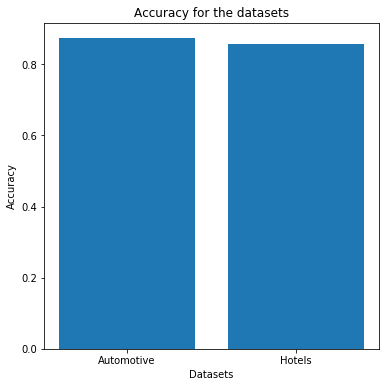

In [67]:
data = [m1,m2]
lables = ['Automotive','Hotels']
plt.figure(figsize = (6,6))
plt.bar(lables, data)
plt.title('Accuracy for the datasets')
plt.xlabel('Datasets')
plt.ylabel('Accuracy')
plt.show()

## 3. Training on Hotel Dataset
Training the model on hotel dataset.

In [56]:
df3.head()

,review,rating
0,Melissa took us on a tour of Asia in the space...,Positive
1,With a group of seven of us visiting Montreal ...,Positive
2,Melissa is a gem! My fiancé found her tour on ...,Positive
3,A perfect day in Montreal! Melissa outfitted u...,Positive
4,I had a really great food truck tour with Meli...,Positive


In [57]:
#training set
X_train = df3["review"]
y_train = df3["rating"]

In [58]:
#test set
X_test_1 = df1["review"]
y_test_1 = df1["rating"]
X_test_2 = df2["review"]
y_test_2 = df2["rating"]

### <font color='Red'>Preprocessing</font>

In [59]:
#numeric format for train set
vectorizer = TfidfVectorizer(ngram_range = (1,2), stop_words='english', min_df=2)
X = vectorizer.fit_transform(X_train)
print(X.shape)
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

(2000, 15501)
Vocabulary has 15501 distinct terms


In [60]:
# Displaying a set of sample terms
print(terms[2000:2010])

['camping', 'campus', 'camry', 'canada', 'canadian', 'canadian passport', 'canadians', 'canal', 'canal shoppes', 'canals']


### <font color='Red'>Traing the model</font>

In [61]:
model_6 = LogisticRegression(random_state=0)
model_6.fit(X, y_train)

/Users/sahil/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### <font color='Red'>Testing and evaluating on Automotive dataset</font>

In [62]:
test_X = vectorizer.transform(X_test_1)
predicted = model_6.predict(test_X)

In [63]:
print("Accuracy = %.2f" % accuracy_score(y_test_1, predicted) )
m1 = accuracy_score(y_test_1, predicted)
print(metrics.classification_report(y_test_1, predicted))
display(pd.crosstab(y_test_1, predicted, rownames=["True"],colnames = ['Predicted'], margins = True))

Accuracy = 0.87
              precision    recall  f1-score   support

    Negative       0.82      0.88      0.85       788
    Positive       0.92      0.87      0.89      1212

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.88      0.87      0.87      2000



Predicted,Negative,Positive,All
True,,,
Negative,690,98,788
Positive,155,1057,1212
All,845,1155,2000


### <font color='Red'>Testing and evaluating on Cafe dataset</font>

In [64]:
test_X_2 = vectorizer.transform(X_test_2)
predicted = model_6.predict(test_X_2)

In [65]:
print("Accuracy = %.2f" % accuracy_score(y_test_2, predicted) )
m2 = accuracy_score(y_test_2, predicted)
print(metrics.classification_report(y_test_2, predicted))
display(pd.crosstab(y_test_2, predicted, rownames=["True"],colnames = ['Predicted'], margins = True))

Accuracy = 0.86
              precision    recall  f1-score   support

    Negative       0.91      0.52      0.66       538
    Positive       0.85      0.98      0.91      1462

    accuracy                           0.86      2000
   macro avg       0.88      0.75      0.79      2000
weighted avg       0.87      0.86      0.84      2000



Predicted,Negative,Positive,All
True,,,
Negative,279,259,538
Positive,26,1436,1462
All,305,1695,2000


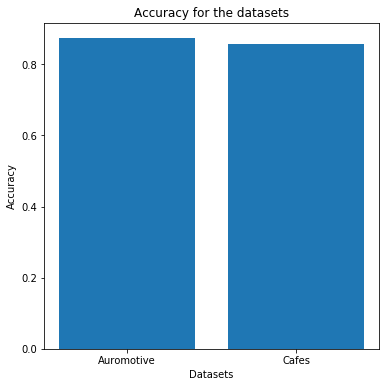

In [68]:
data = [m1,m2]
lables = ['Auromotive','Cafes']
plt.figure(figsize = (6,6))
plt.bar(lables, data)
plt.title('Accuracy for the datasets')
plt.xlabel('Datasets')
plt.ylabel('Accuracy')
plt.show()

1. The model is trained on the data from **Automotive** dataset and its performance is evaluated on the data from **Cafe** and **Hotel** dataset.
    1. The model is evaluated on the cafe dataset first. The accuracy of the model is 0.83, which can be conisdered good, but we will look at the confusion matrix. Out of 538 negative reviews, 229 reviews are predicted as negative while 309 reviews are predicted as postive, which is not good. The F1 score for negative reviews is 0.57. Out of 1462 positive reviews, the model predicts 1426 reviews as positive whereas only 36 negative, which is good. The F1 score for positive class is 0.89. So it can be said that the model trained on automotive dataset is classifying the positive reviews form the cafe dataset well, but not the negative reviews.
    2. The model is now evaluated on the hotel dataset. The accuracy of the model is 0.85, which is good. Considering the confuison matrix, we can see that out of 824 negative reviews, 562 reviews are predicted correctly as negative but 262 reviews are predicted as positive which is inocrrect. The F1 score for negative reviews is 0.79. For positve reviews, out of 1176 positive reviews, 1143 reviews are coorectly predicted as postive and only 33 positive reviews are incorrectly negative. The F1 score for positive review is 0.89.
    
      The model when evaluated on hotel data gives a better accuracy. In both the cases, it predicts well for positive reviews.
    
    
2. The model is trained on the data from **Cafe** dataset and its performace is evaluated on the data from **Automotive** and **Hotel** dataset.
    1. The model is evaluated on the automotive dataset. The accuracy of the model is 0.79. Considering the confusion matrix, we can see that out of 788 negative reviews, 459 reviews are correctly predicted as negative, but 329 reviews are predicted as positive, which is not very good. The F1 score for negative class is 0.69. Further oyt of 1212 positive reviews, 1123 reviews are correctly predcited as positve whereas only 89 reviews are predicted as negative. We can say that the model is predicting positive class well. The F1 score for positive class is 0.84.
    2. The model is then evaluetd on hotle datatset as test set. The accuracy of the model is 0.78. Considering the confusion matrix, we can see that out of 824 negative reviews only 418 reviews are predicted correctly as negative and 406 are predicted incorrectly as positive, which is not good. The F1 score for positive reviews is 0.66. Now, for positive reviews, out of 1176 positive reviews, 1143 reviews are correctly predicted as positive and only 33 are incorrectly predicted as negative. The F1 score for positive reviews is 0.84. 
    
    The model evaluated on automotive dataset gives a better accuracy. It can be concluded that in both cases, the model is predicted well for the positive reviews, but not that good for negative reviews.
    
    
3. The model is trained on the data from **Hotel** dataset and its performace is evaluated on the data from **Automotive** and **Cafe** dataset.
    1. The model is evaluated on automotive dataset. The accuracy of the model is 0.87, which is good. Now considering the confusion matrix, out of 788 negative reviews, 690 reviews are correctly classified as negative reviews and only 98 reviews are incorrectly classified as positive reviews, which is good. The F1 score for negative reviews is 0.85. Out of 1212 positive reviews, 1155 reviews are correctly predicted as positive and 845 reviews are incorrectly predicted as negative, which is not bad. The F1 score for positive reviews is 0.89.
    2. The model is revaluated on cafe dataset. The accuracy of the model is 0.86, which is agin good. Considering the confusion matrix, out of 538 negtive reviews, 279 reviews are correctly predicted as negative whereas 259 reviews are incorrectly predicted as positive, which is not good. The F1 score for the negative reviews is 0.66. Out of 1462 positive reviews, 1436 reviews are correctly predicted as positive, and only 26 are incorrectly predicted as negative, which is good. The F1 score for the positive reviews is 0.91.
   
    The model evaluted on automotive dataset gives a better accuracy. In the first case (automotive dataset), the model predicts well in both positive and negative reviews, while in the second case, the model predicts well for positive reviews, but not for negative reviews.